## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
import tensorflow as tf
from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
from random import sample 
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
103507,00027623_010.png,Atelectasis|Cardiomegaly,10,27623,49,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027623_010.png
69233,00017088_002.png,No Finding,2,17088,42,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017088_002.png
15883,00004196_010.png,No Finding,10,4196,60,M,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00004196_010.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df.drop('Unnamed: 11', axis=1, inplace=True)
all_xray_df.rename(columns={'Pneumonia':'pneumonia_class'}, inplace=True)

In [5]:
all_xray_df['pneumonia_class']=all_xray_df['pneumonia_class'].replace({1:'pneumonia',0:'no_pneumonia'})

## Create your training and testing data:

Here we are going to split data in order to create our train and validation sets according to the following:

* Split the data into train and validation with 80-20 according to pneumonia_class.
* Correct the balance of the train_data to 50-50.
* Correct the balance in the validation according to the presence of pneumonia in this clinical situation. In this case we decide to do an 80-20.

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # split the data into train and validation with 80-20 according to pneumonia_class
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['pneumonia_class'])
    
    # correct the balance of the train_data to 50-50
    pneumonia_indx = train_data[train_data['pneumonia_class']=='pneumonia'].index.tolist()
    no_pneumonia_indx = train_data[train_data['pneumonia_class']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx,len(pneumonia_indx))
    train_data = train_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    # correct the balance in the validation according to the presence of pneumonia in this clinical situation
    pneumonia_indx = val_data[val_data['pneumonia_class']=='pneumonia'].index.tolist()
    no_pneumonia_indx = val_data[val_data['pneumonia_class']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx,4*len(pneumonia_indx))
    val_data = val_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    return train_data, val_data

In [7]:
train_data, val_data=create_splits(all_xray_df)

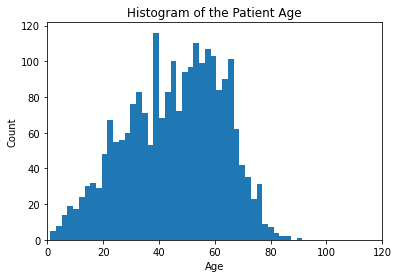

In [8]:
plt.hist(train_data['Patient Age'],bins=200);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

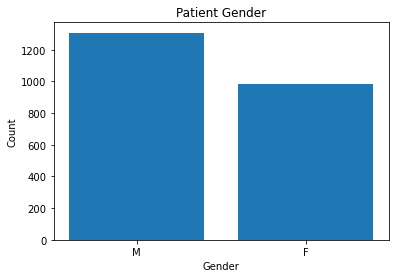

In [9]:
Gender=train_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

In [10]:
val_data.shape

(1430, 27)

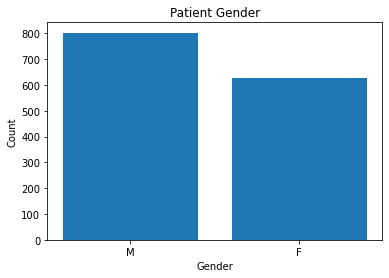

In [11]:
Gender=val_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

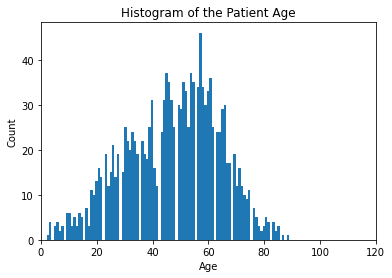

In [12]:
plt.hist(val_data['Patient Age'],bins=100);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

In [13]:
train_data.query('pneumonia_class=="pneumonia"')['pneumonia_class'].count()/len(train_data)

0.5

In [14]:
val_data.query('pneumonia_class=="pneumonia"')['pneumonia_class'].count()/len(val_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [15]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg=ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return my_train_idg,my_val_idg


def make_train_gen(my_train_idg,train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
        train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224),
                                             batch_size = 64
                                                     )
        return train_gen


def make_val_gen(my_val_idg,val_df):
    
         val_gen = my_val_idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224, 224),
                                             batch_size = 256
                                                     )

         return val_gen

In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_train_idg,my_val_idg=my_image_augmentation()
val_gen=make_val_gen(my_val_idg,val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


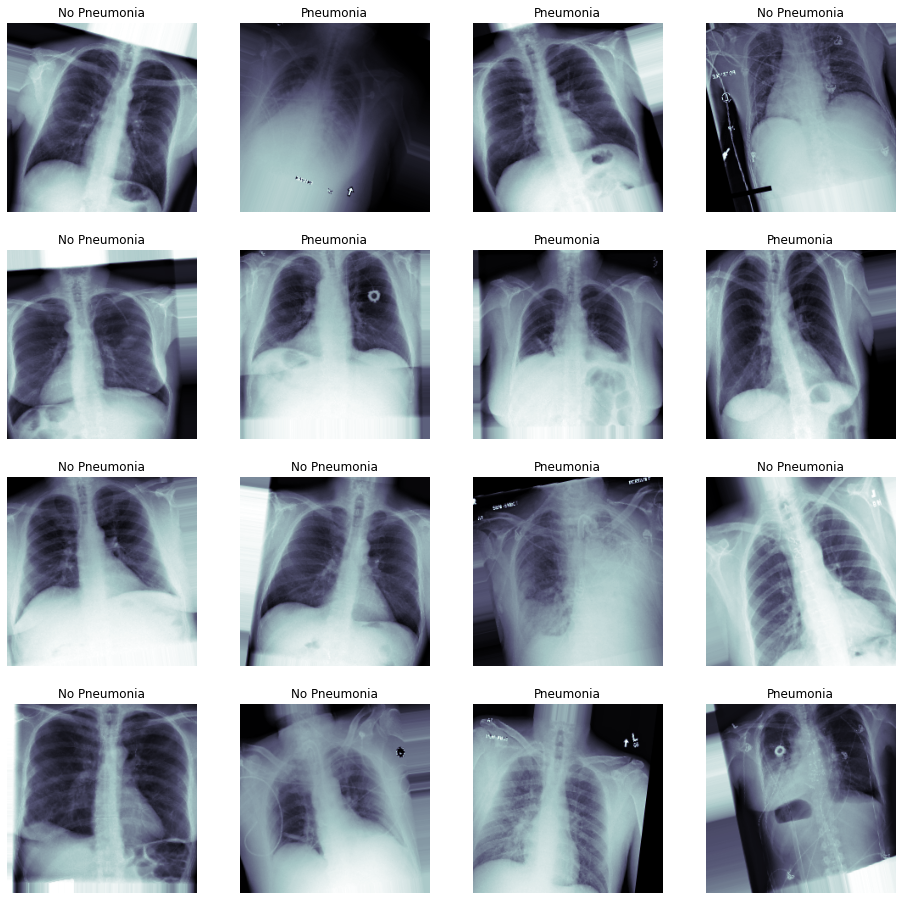

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen=make_train_gen(my_train_idg,train_data)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [19]:
vgg_model=load_pretrained_model()
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 
    my_model.add(Flatten())
    
    #my_model.add(Dropout(0.5))            
    #my_model.add(Dense(512, activation='relu'))
    
    #my_model.add(Dropout(0.5))
    #my_model.add(Dense(128, activation='relu'))
    
    # Add a dense (aka. fully-connected) layer.
    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
my_model=build_my_model(vgg_model)

In [22]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="my_model_weights.hdf5"

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [23]:
## train your model

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 10, callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 0.6832 - binary_accuracy: 0.5585 - val_loss: 0.6569 - val_binary_accuracy: 0.5664

Epoch 00001: val_loss improved from inf to 0.65690, saving model to my_model_weights.hdf5
Epoch 2/10
36/36 [==============================] - 61s 2s/step - loss: 0.6576 - binary_accuracy: 0.6026 - val_loss: 0.6754 - val_binary_accuracy: 0.6016

Epoch 00002: val_loss did not improve from 0.65690
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6457 - binary_accuracy: 0.6332 - val_loss: 0.6261 - val_binary_accuracy: 0.6484

Epoch 00003: val_loss improved from 0.65690 to 0.62614, saving model to my_model_weights.hdf5
Epoch 4/10
36/36 [==============================] - 60s 2s/step - loss: 0.6436 - binary_accuracy: 0.6358 - val_loss: 0.6228 - val_binary_accuracy: 0.6328

Epoch 00004: val_loss improved from 0.62614 to 0.62280, saving model to my_model_weights.hdf5
Epoch 5/10
36/36 [==============================] -

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.save_weights(weight_path)
my_model.save('my_model.hdf5')

In [25]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

256/256 [==============================] - 5s 20ms/step


In [26]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def plot_f1t(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1=2*(precision*recall)/(precision+recall)
    c_ax.plot(f1[0:len(thresholds)], thresholds, label = 'f1_score vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1_score')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

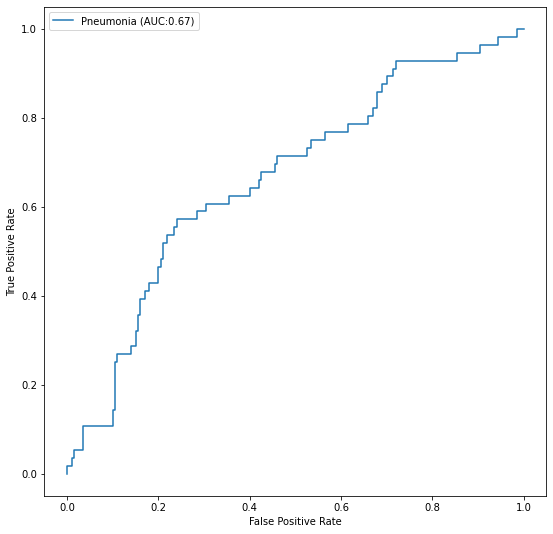

In [27]:
## plot figures

plot_auc(valY, pred_Y)

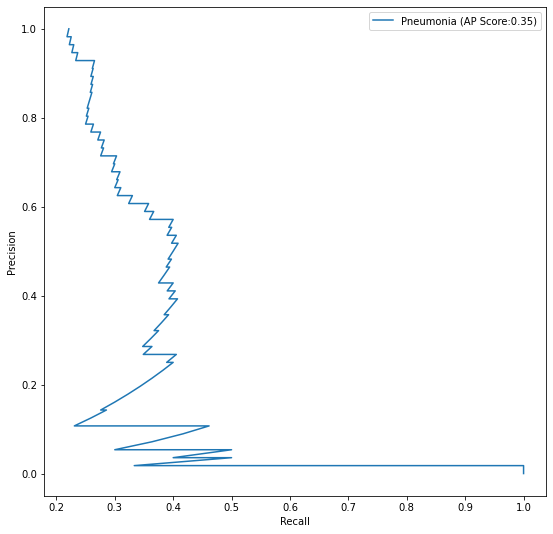

In [28]:
plot_pr(valY, pred_Y)

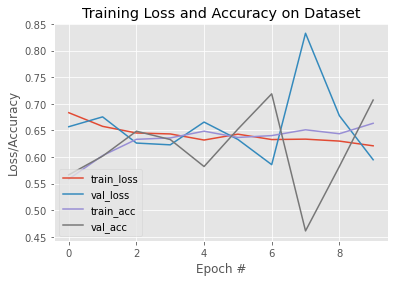

In [29]:
plot_history(history)

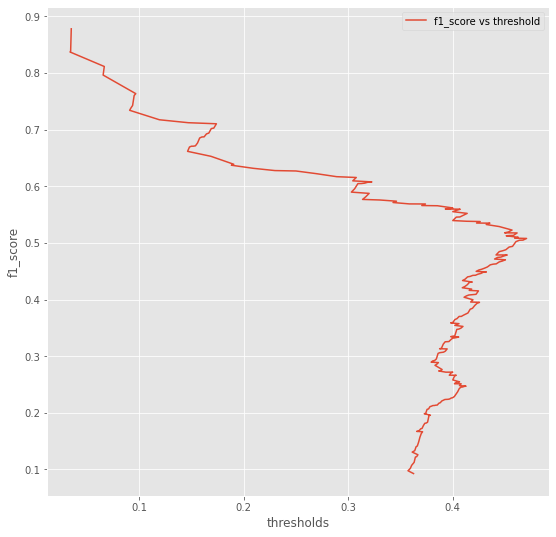

In [30]:
plot_f1t(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [34]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
# Look at the threshold where recall is 0.0
recall_value = 0.7
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.29770992366412213
Recall is: 0.6964285714285714
Threshold is: 0.395578
F1 Score is: 0.41711229946524064


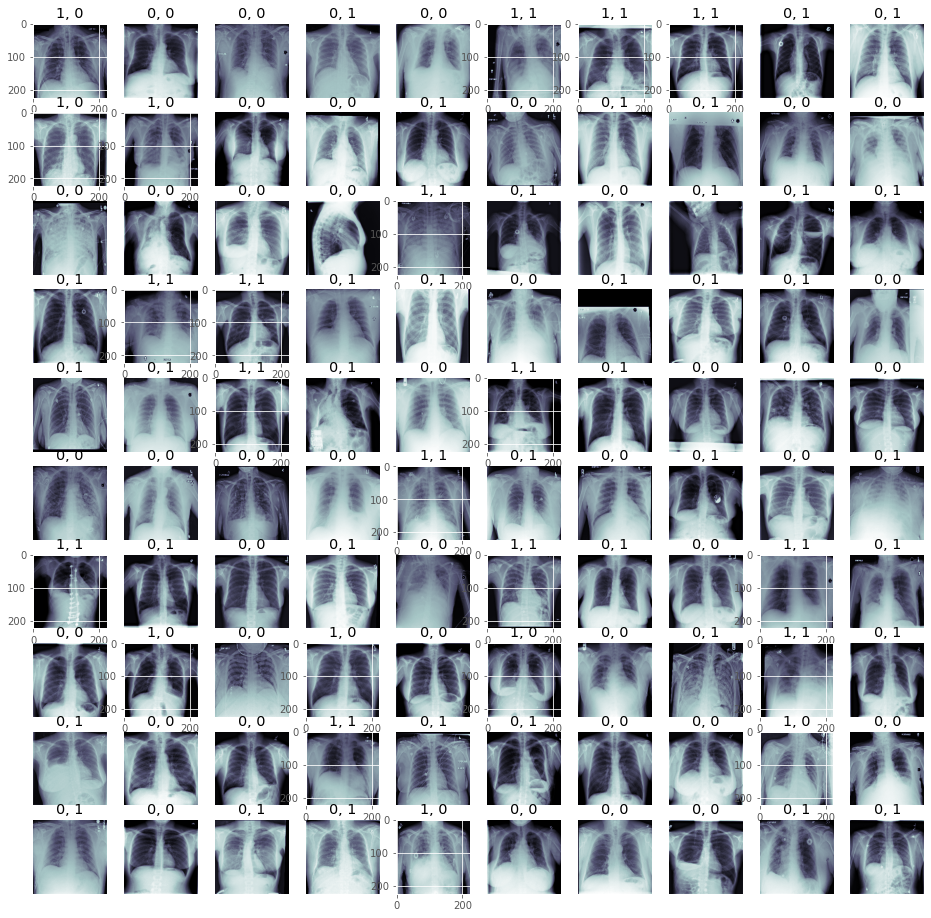

In [35]:
## Let's look at some examples of true vs. predicted with our best model: 



fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            if pred_Y[i] > thresholds[idx]:
                c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
        else:
            if pred_Y[i] > thresholds[idx]: 
                c_ax.set_title('0, 1')
            else:
                c_ax.set_title('0, 0')
            c_ax.axis('off')
            i=i+1

In [36]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)